# S\$NEER Regression and Style Analysis
by Chee-Foong on 31 Dec 2020

## Summary

This analysis outlines the process how one can download the relevant data from MAS website to contruct a regression model to estimate the S$NEER index values.  One can also estimate the currencies weights that make up the S\\$NEER index using style analysis.

## Reference
1. [**MAS**: Past Monetary Policy Decisions](https://www.mas.gov.sg/monetary-policy/past-monetary-policy-decisions)
2. [**MAS**: Frequently Asked Questions on Singapore’s Monetary Policy Framework](https://www.mas.gov.sg/-/media/MAS/Monetary-Policy-and-Economics/Monetary-Policy/MP-Framework/FAQs/FAQs_20181010.pdf?la=en&hash=C5CE32786C39677FCD558562951B7E90F4FBBF15)
3. [**MAS**: API for Exchange Rates - End of Period, Weekly](https://secure.mas.gov.sg/api/APIDescPage.aspx?resource_id=3a5b732e-9490-4629-a398-d0c414204ee0)
4. [**CFI**: Trade-Weighted Exchange Rate](https://corporatefinanceinstitute.com/resources/knowledge/economics/trade-weighted-exchange-rate/)
5. [**ANZ**: SGD: ESTIMATING THE S$NEER AND POLICY PARAMETERS - 15 Oct 2015](https://anzlive.secure.force.com/servlet/servlet.FileDownload?file=00P1400000iR61fEAC)
6. [**UOB**: Recalibrating The UOB S\$NEER](https://www.uobgroup.com/web-resources/uobgroup/pdf/research/MN_190321.pdf)
7. [**Maybank**: SGD NEER Update and Proxy
Basket for Preferred Play - 3 Jul 2019](https://www.maybank2u.com.sg/iwov-resources/sg/pdf/investment-insurance/insight/fx-insight-03-07-19.pdf)
8. [**Credit Suisse**: SGD NEER recalibration - 3 Feb 2017](https://plus.credit-suisse.com/rpc4/ravDocView?docid=V6xJ0Y2AD-WEpljI)
9. [**Straits Times**: What is monetary policy and why does the MAS keep talking about the S\$NEER?](https://www.straitstimes.com/business/what-is-monetary-policy-and-why-does-the-mas-keep-talking-about-the-sneer)

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *
from edge import *

import edge_risk_kit as erk

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label, Box

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(12,6)})

DATA_FOLDER = '../data/'

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import matplotlib.ticker as mtick

## Helper Functions

In [3]:
## Function to format the date on the downloaded file on S$NEER 
def processDate(dt):
    new_dt = str(dt).strip().split(' ')

    year, month, day = np.nan, np.nan, np.nan
    
    if len(new_dt) == 1:
        day = new_dt[0]
        
    if len(new_dt) == 2:
        month = new_dt[0]
        day = new_dt[1]
        
    if len(new_dt) == 3:
        year = new_dt[0]
        month = new_dt[1]
        day = new_dt[2]
        
    return year, month, day

def bollingerband(px, window, num=1):
    mean = px.rolling(window).aggregate(np.mean)
    sd = px.rolling(window).aggregate(np.std)
    upper, lower = mean + num*sd, mean - num*sd
    return upper, lower

def plot_scatter(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()    
    
def plot_pairs(data, columns):
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()

## S\$ Nominal Effective Exchange Rate Index

From the MAS website, download the official S\$NEER index.

In [4]:
URL = 'https://www.mas.gov.sg/statistics/exchange-rates'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
SITE = 'http://www.mas.gov.sg'

In [5]:
for div in soup.findAll("div", {"class": "_mas-typeset contain mas-rte-content"}):
    links = div.findAll('a')
    
sneer_link = SITE + links[1]['href']

In [6]:
sneer_link

'http://www.mas.gov.sg/-/media/MAS/EPG/Statistics/01_S$NEER/S$NEER_202012-1.xlsx?la=en&hash=4FF75D824408298C1AD7D2479633A4737625117A'

In [7]:
r = requests.get(sneer_link, allow_redirects=True)

with open(DATA_FOLDER + 'S$NEER_latest.xlsx', 'wb') as f:
    f.write(r.content)

Saving the excel file

In [8]:
sneer_datafile = DATA_FOLDER + 'S$NEER_latest.xlsx'

Extracting the index values for analysis

In [9]:
import xlrd
xls = xlrd.open_workbook(sneer_datafile, on_demand=True)
sheets = xls.sheet_names()

In [10]:
sneer = []

for sheet in sheets:
    data = pd.read_excel(sneer_datafile, sheet).dropna()
    required_cols = ['date', 'sneer']
    data.columns = required_cols
    data.sneer = data.sneer.astype('str')
    data = data.loc[data.sneer.str.contains("\d+")]
    data.sneer = data.sneer.astype('float')    
    data['year'], data['month'], data['day'] = zip(*data.date.apply(lambda x: processDate(x)))
    data['year'] = data.year.fillna(method='ffill')
    data['month'] = data.month.fillna(method='ffill')
    data['day'] = data.day.fillna(method='ffill')
    data['date'] = pd.to_datetime(data.day + ' ' + data.month + ' ' + data.year)
    data = data[required_cols]
    sneer.append(data)
    
sneer = pd.concat(sneer)  
sneer.set_index('date', inplace=True)

Plotting the S$NEER index

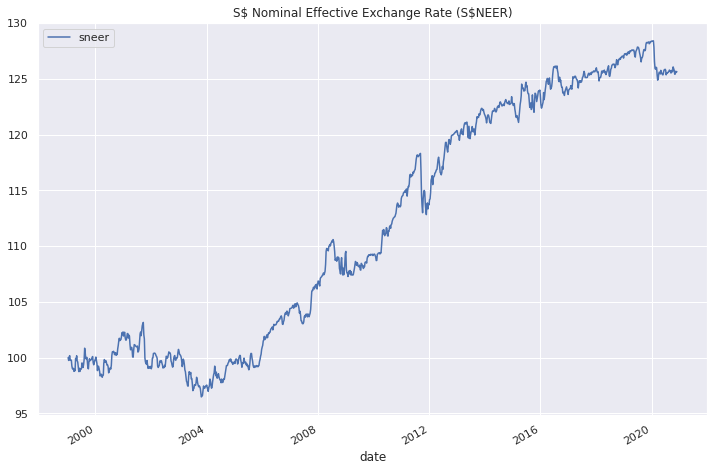

In [11]:
sneer.plot(title='S\$ Nominal Effective Exchange Rate (S\$NEER)', figsize=(12,8))
plt.show()

How the index will look like when rebased on a particular date

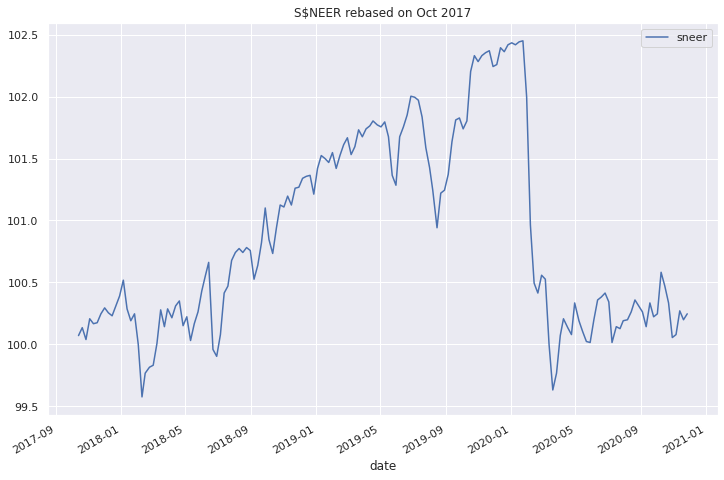

In [12]:
rets = sneer['2017-10':].pct_change().dropna()
((1+rets).cumprod()*100).plot(title = 'S\$NEER rebased on Oct 2017', figsize=(12,8))
plt.show()

Statistical Analysis of S$NEER

In [13]:
rets = sneer.pct_change().dropna()
erk.summary_stats(rets, 0, 52)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
sneer,0.010455,0.021177,-0.42843,7.128973,0.004727,0.00664,0.49368,-0.064754


104 Weeks Moving Averages and Bollinger Bands

In [14]:
ROLLING_WINDOW = 104
sneer['movavg'] = sneer.sneer.rolling(ROLLING_WINDOW).aggregate(np.mean)
sneer['upper_2sd'], sneer['lower_2sd'] = bollingerband(sneer.sneer, ROLLING_WINDOW, 2)

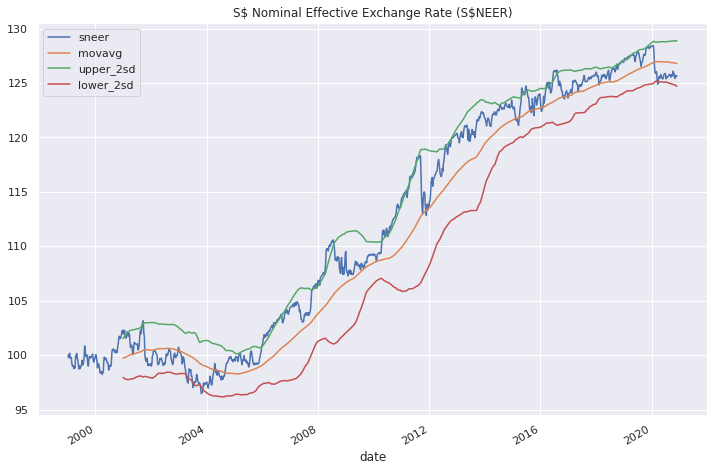

In [15]:
sneer.plot(title='S\$ Nominal Effective Exchange Rate (S\$NEER)', figsize=(12,8))
plt.show()

Backup the formatted S$NEER Data

In [16]:
sneer.to_csv(DATA_FOLDER + 'sneer.csv')

---
## Exchange Rate

Using MAS API, to download the exchange rates for the reconstruction of the S$NEER index.  The weekly exchange rate downloaded are priced in SGD per unit or 100 units of respective currencies.  The currency abbreviations have been renamed for simplicity.

In [17]:
num_of_records = 5000
resource_id = '3a5b732e-9490-4629-a398-d0c414204ee0'

url = 'https://eservices.mas.gov.sg/api/action/datastore/search.json?resource_id=' + resource_id + '&limit=' + str(num_of_records)
headers = {'user-agent1':'edge-project/0.0.1'}

req = requests.get(url)
results = req.json()

In [18]:
exchrate = pd.DataFrame(results['result']['records'])
exchrate.replace('', np.nan, inplace=True)
exchrate.end_of_week = pd.to_datetime(exchrate.end_of_week)
exchrate.set_index('end_of_week', inplace=True)
exchrate = exchrate.astype('float')
exchrate = exchrate.drop(['preliminary','timestamp'], axis=1)

In [19]:
exchrate.dropna(inplace=True)
exchrate.columns = exchrate.columns.str.replace('_sgd','').str.replace('_100','').str.upper()
exchrate.tail()

,EUR,GBP,USD,AUD,CAD,CNY,HKD,INR,IDR,JPY,...,MYR,TWD,NZD,PHP,QAR,SAR,CHF,THB,AED,VND
end_of_week,,,,,,,,,,,,,,,,,,,,,
2020-12-04,1.6196,1.7932,1.3334,0.9902,1.0368,20.39,17.20,1.8051,0.009436,1.2839,...,32.81,4.7200,0.9409,2.7759,36.62,35.55,1.4968,4.4202,36.30,0.005764
2020-12-11,1.6215,1.7766,1.3338,1.0083,1.0480,20.40,17.21,1.8106,0.009463,1.2819,...,32.90,4.7390,0.9474,2.7743,36.62,35.56,1.5058,4.4436,36.31,0.005767
2020-12-18,1.6244,1.7950,1.3264,1.0084,1.0409,20.28,17.11,1.8038,0.009396,1.2826,...,32.85,4.7134,0.9458,2.7601,36.43,35.36,1.4990,4.4531,36.11,0.005736
2020-12-24,1.6227,1.8011,1.3291,1.0089,1.0347,20.35,17.14,1.8000,0.009360,1.2837,...,32.74,4.7254,0.9438,2.7661,36.50,35.44,1.4976,4.4025,36.18,0.005746
2020-12-31,1.6249,1.8005,1.3221,1.0178,1.0376,20.24,17.05,1.8062,0.009410,1.2814,...,32.94,4.7100,0.9549,2.7531,36.31,35.25,1.4991,4.4171,35.99,0.005727


In [20]:
exchrate.to_csv(DATA_FOLDER + 'exchrate.csv')

---
## List of Monetary Policy Decisions

From MAS website, download all past monetary policy decisions.

In [21]:
URL = 'https://www.mas.gov.sg/monetary-policy/past-monetary-policy-decisions'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [22]:
policy_table = soup.find("table")
policy_table_header = policy_table.thead.find_all("tr")
policy_table_data = policy_table.tbody.find_all("tr")

In [23]:
headers = [header.text.strip().replace(' ','_') for header in policy_table_header[1].find_all('th')]   
headers.insert(0, 'Policy_Date')
headers

['Policy_Date',
 'Slope_of_Policy_Band',
 'Width_of_Policy_Band',
 'Level_at_which_Policy_Band_is_Centred']

In [24]:
decisions = []
for row in policy_table_data:
    decision = {}
    cell = row.find_all('td')
    decision['date'] = cell[0].text.strip()        
    decision['slope'] = cell[1].text.strip()         
    decision['width'] = cell[2].text.strip()         
    decision['level'] = cell[3].text.strip()
    decisions.append(decision)
    
decisions = pd.DataFrame(decisions)
decisions.date = decisions.date.apply(lambda x: x[0:11])
decisions.date = pd.to_datetime(decisions.date)
decisions.set_index('date', inplace=True)

In [25]:
decisions = decisions.sort_index()

In [26]:
exchrate.to_csv(DATA_FOLDER + 'mas_policy_decisions.csv')

---
## Estimating the S\$NEER index using Regression Analysis

Taking reference from [CFI website](https://corporatefinanceinstitute.com/resources/knowledge/economics/trade-weighted-exchange-rate/), 

\begin{equation}  
\label{eq:SNEER}  
\textrm{TWI}_t = 100 \times \prod\Bigg[\frac{e_{it}}{e_{ot}}\Bigg]^{w_{it}} \times \textrm{IND} \\
\\
\ln{\frac{\textrm{TWI}_t}{\textrm{IND}}} = 100 \times w_{it} \times \ln{\prod\Bigg[\frac{e_{it}}{e_{io}}\Bigg]{}} \\
\\
\ln{\frac{\textrm{TWI}_t}{\textrm{IND}}} = 100 \times [w_{1t}\ln{[\frac{e_{1t}}{e_{1o}}]} + w_{2t}\ln{[\frac{e_{2t}}{e_{2o}}]} + w_{3t}\ln{[\frac{e_{3t}}{e_{3o}}]} + \dots]
\end{equation}  

where  
- **$\textrm{TWI}_t$** = trade-weighted index of current period
- **$\prod$** = the product of the bracketed term over the currencies pairs against SGD  
- **$e_{it}$** = the number of foreign currency units for trading partner i per SGD at time t  
- **$e_{io}$** = the number of foreign currency units for trading partner i per SGD at time o  
- **$w_{it}$** = the trade weightfor the currency of trading partner i at time t  
- **$\textrm{IND}$** = trade-weighted index of last weight update

Note that the weekly point data will be transformed according to the form like in the last equation for regression analysis.

### Rebase (or reweighting) dates and index values
Assuming possible index rebase dates when there is a decision to re-centre decision.

In [27]:
# decisions = decisions['2012':'2019']
rebase_dates = decisions[decisions.level != '-'].index.sort_values().to_list()

In [28]:
if len(rebase_dates) == 0: rebase_dates.append(decisions.index[0])

Given that the S\\$NEER index and exchange rates are weekly points and the monetary policy decisions may come in any time of the year, we will resample the S\\$NEER index and exchange rates to daily points by forward filling.  Purpose of the daily data points is rebasing the weekly points for regression analysis later.

In [29]:
sneer_daily = sneer.sneer.resample('D').ffill()

In [30]:
prevailing_sneer = sneer_daily[rebase_dates].to_frame()
prevailing_sneer.columns = ['sneer']

In [31]:
prevailing_sneer

,sneer
date,
2002-01-02,99.22
2003-07-10,97.04
2008-04-10,107.75
2009-04-14,107.43
2010-04-14,109.39
2011-04-14,115.32
2020-03-30,125.06


In [32]:
rebase_levels = pd.concat([decisions, prevailing_sneer], axis=1, join='inner')
rebase_levels.index.name = 'policy_date'

In [33]:
rebase_levels

,slope,width,level,sneer
policy_date,,,,
2002-01-02,-,Restore narrower band,"Re-centre downwards, at prevailing level of th...",99.22
2003-07-10,-,-,"Re-centre downwards, at prevailing level of th...",97.04
2008-04-10,-,-,"Re-centre upwards, at prevailing level of the ...",107.75
2009-04-14,-,-,"Re-centre downwards, at prevailing level of th...",107.43
2010-04-14,Increase,-,"Re-centre upwards, at prevailing level of the ...",109.39
2011-04-14,-,-,"Re-centre upwards, to below prevailing level o...",115.32
2020-03-30,Set at 0%,-,"Re-centre downwards, at prevailing level of th...",125.06


### Regression Data

Exchange rates will have to be inversed to be consistent with the index:  Higher index value represent SGD strength and vice versa.

In [34]:
data = pd.concat([sneer.sneer, 1/exchrate], axis=1).dropna()

In [35]:
# data = data['2012':'2019']

Dropping currencies that are pegged to USD

In [36]:
to_drop = ['HKD', 'QAR', 'SAR', 'AED']

In [37]:
data.drop(to_drop, axis=1, inplace=True)

Forward fill the weekly data to generate daily data for rebase calculation on rebase data.

In [38]:
data_daily = data.resample('D').ffill()
data_daily.tail()

,sneer,EUR,GBP,USD,AUD,CAD,CNY,INR,IDR,JPY,KRW,MYR,TWD,NZD,PHP,CHF,THB,VND
2020-11-23,125.60,0.626763,0.561199,0.744325,1.021450,0.973425,0.048972,0.551815,105.641242,0.772678,8.285004,0.030451,0.212409,1.075731,0.359221,0.677415,0.225836,172.503019
2020-11-24,125.60,0.626763,0.561199,0.744325,1.021450,0.973425,0.048972,0.551815,105.641242,0.772678,8.285004,0.030451,0.212409,1.075731,0.359221,0.677415,0.225836,172.503019
2020-11-25,125.60,0.626763,0.561199,0.744325,1.021450,0.973425,0.048972,0.551815,105.641242,0.772678,8.285004,0.030451,0.212409,1.075731,0.359221,0.677415,0.225836,172.503019
2020-11-26,125.60,0.626763,0.561199,0.744325,1.021450,0.973425,0.048972,0.551815,105.641242,0.772678,8.285004,0.030451,0.212409,1.075731,0.359221,0.677415,0.225836,172.503019
2020-11-27,125.66,0.626566,0.558784,0.747105,1.013685,0.972290,0.049164,0.551359,105.440742,0.776578,8.250825,0.030423,0.213106,1.065076,0.359170,0.676682,0.226270,173.040318


In [39]:
data_rebase = []
debug = True

for k, v in enumerate(rebase_dates):
    base_dt = np.nan
    
    if k+1 == len(rebase_dates):
        base_dt = rebase_dates[k]
        base = data_daily.loc[base_dt]
        rebase = data[rebase_dates[k]:]/base
        data_rebase.append(rebase)
    else:
        if data[:rebase_dates[k]].shape[0] > 0:
            base_dt = rebase_dates[k]
            base = data_daily.loc[base_dt]
            rebase = data[rebase_dates[k]:rebase_dates[k+1]]/base
            data_rebase.append(rebase)
        else:
            next
            
    if debug:
        print('{} - Rebase Date: {} - Policy Date: {}'.format(k, base_dt, v))
            

0 - Rebase Date: nan - Policy Date: 2002-01-02 00:00:00
1 - Rebase Date: nan - Policy Date: 2003-07-10 00:00:00
2 - Rebase Date: 2008-04-10 00:00:00 - Policy Date: 2008-04-10 00:00:00
3 - Rebase Date: 2009-04-14 00:00:00 - Policy Date: 2009-04-14 00:00:00
4 - Rebase Date: 2010-04-14 00:00:00 - Policy Date: 2010-04-14 00:00:00
5 - Rebase Date: 2011-04-14 00:00:00 - Policy Date: 2011-04-14 00:00:00
6 - Rebase Date: 2020-03-30 00:00:00 - Policy Date: 2020-03-30 00:00:00


Rebased data

In [40]:
data_rebase = pd.concat(data_rebase)
data_rebase.tail()

,sneer,EUR,GBP,USD,AUD,CAD,CNY,INR,IDR,JPY,KRW,MYR,TWD,NZD,PHP,CHF,THB,VND
2020-10-30,1.002879,0.991721,0.994557,1.046491,0.907540,0.993955,0.990691,1.039312,0.951523,1.007733,0.977686,1.020732,0.992560,0.945850,0.999326,0.996515,1.008187,1.027032
2020-11-06,1.003119,0.990230,0.989396,1.056876,0.890772,0.988174,0.993124,1.046262,0.936655,1.007733,0.985833,1.027309,1.001565,0.935001,1.006578,0.995247,1.002319,1.036904
2020-11-13,1.005038,0.992343,0.990793,1.057033,0.894699,0.993955,0.992636,1.055694,0.932717,1.023006,0.978495,1.024480,1.000803,0.929720,1.007911,1.007590,0.988963,1.037082
2020-11-20,1.004318,0.990975,0.984399,1.062226,0.891318,0.992310,0.990206,1.053305,0.937249,1.016999,0.980116,1.019488,1.005926,0.920719,1.011495,1.007181,0.995619,1.042091
2020-11-27,1.004798,0.990664,0.980163,1.066194,0.884541,0.991152,0.994100,1.052434,0.935470,1.022132,0.976073,1.018558,1.009227,0.911599,1.011350,1.006090,0.997534,1.045337


Logging the rebased data to generate the returns for regression purpose

In [41]:
data_log = np.log(data_rebase)

In [42]:
data_log.tail()

,sneer,EUR,GBP,USD,AUD,CAD,CNY,INR,IDR,JPY,KRW,MYR,TWD,NZD,PHP,CHF,THB,VND
2020-10-30,0.002874,-0.008314,-0.005458,0.045443,-0.097017,-0.006064,-0.009353,0.038559,-0.049691,0.007703,-0.022567,0.020520,-0.007468,-0.055671,-0.000675,-0.003491,0.008154,0.026673
2020-11-06,0.003114,-0.009818,-0.010661,0.055318,-0.115667,-0.011897,-0.006900,0.045224,-0.065440,0.007703,-0.014268,0.026943,0.001564,-0.067208,0.006556,-0.004764,0.002316,0.036239
2020-11-13,0.005025,-0.007687,-0.009250,0.055466,-0.111268,-0.006064,-0.007391,0.054198,-0.069654,0.022746,-0.021740,0.024185,0.000803,-0.072872,0.007880,0.007561,-0.011098,0.036411
2020-11-20,0.004309,-0.009066,-0.015724,0.060366,-0.115054,-0.007720,-0.009843,0.051933,-0.064806,0.016856,-0.020084,0.019301,0.005909,-0.082601,0.011430,0.007155,-0.004391,0.041229
2020-11-27,0.004786,-0.009380,-0.020036,0.064095,-0.122686,-0.008887,-0.005917,0.051106,-0.066706,0.021891,-0.024218,0.018388,0.009185,-0.092555,0.011286,0.006072,-0.002469,0.044339


In [43]:
Xy = data_log

In [44]:
X = Xy.iloc[:,1:]
y = Xy.iloc[:,0]

print(X.shape)
print(y.shape)

(660, 17)
(660,)


### Regression Analysis

Observed that the p-values for some currencies are not small.  These currencies are not significant contributors to the estimation of the S\\$NEER index.  We removed these currencies and run the regression analysis again.  As expected, the $R^2$ remain close to 1.

In [45]:
model = erk.regress(y, X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sneer   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.205e+04
Date:                Thu, 31 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:11:34   Log-Likelihood:                 3199.2
No. Observations:                 660   AIC:                            -6362.
Df Residuals:                     642   BIC:                            -6281.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EUR            0.1125      0.003     33.050      0.000       0.106       0.119
GBP            0.0312      0.002     13.591      0.000       0.027       0.036
USD            0.1833      0.008     23.188      0.000       0.168       0.199
AUD            0.0540      0.004     14.680      0.000       0.047       0.061
CAD            0.0112      0.004      2.753      0.006       0.003       0.019
CNY            0.1615      0.004     36.777      0.000       0.153       0.170
INR            0.0317      0.002     13.364      0.000       0.027       0.036
IDR            0.0361      0.003     12.286      0.000       0.030       0.042
JPY            0.1020      0.002     61.113      0.000       0.099       0.105
KRW            0.0203      0.003      6.722      0.000       0.014       0.026
MYR            0.1313      0.004     35.222      0.000       0.124       0.139
TWD            0.0364      0.006      6.407      0.000       0.025       0.048
NZD           -0.0008      0.003     -0.254      0.799      -0.007       0.006
PHP            0.0201      0.004      5.422      0.000       0.013       0.027
CHF        -5.883e-05      0.004     -0.016      0.987      -0.007       0.007
THB            0.0225      0.003      6.894      0.000       0.016       0.029
VND            0.0198      0.006      3.476      0.001       0.009       0.031
Alpha         -0.0007      0.000     -2.275      0.023      -0.001      -0.000
==============================================================================
Omnibus:                       82.466   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              466.885
Skew:                           0.374   Prob(JB):                    4.14e-102
Kurtosis:                       7.052   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
remove_ccy = model.pvalues[model.pvalues > 0.05].index.to_list()
remove_ccy

['NZD', 'CHF']

In [47]:
Xy = Xy.drop(remove_ccy, axis=1)

In [48]:
X = Xy.iloc[:,1:]
y = Xy.iloc[:,0]

print(X.shape)
print(y.shape)

model = erk.regress(y, X)
model.summary()

(660, 15)
(660,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sneer   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.369e+04
Date:                Thu, 31 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:11:34   Log-Likelihood:                 3199.1
No. Observations:                 660   AIC:                            -6366.
Df Residuals:                     644   BIC:                            -6294.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EUR            0.1125      0.003     37.645      0.000       0.107       0.118
GBP            0.0313      0.002     14.165      0.000       0.027       0.036
USD            0.1839      0.007     24.669      0.000       0.169       0.199
AUD            0.0536      0.003     17.171      0.000       0.047       0.060
CAD            0.0113      0.004      2.822      0.005       0.003       0.019
CNY            0.1616      0.004     36.978      0.000       0.153       0.170
INR            0.0318      0.002     14.616      0.000       0.028       0.036
IDR            0.0361      0.003     12.333      0.000       0.030       0.042
JPY            0.1020      0.002     64.020      0.000       0.099       0.105
KRW            0.0198      0.002      8.121      0.000       0.015       0.025
MYR            0.1315      0.004     35.651      0.000       0.124       0.139
TWD            0.0366      0.005      6.690      0.000       0.026       0.047
PHP            0.0200      0.003      5.974      0.000       0.013       0.027
THB            0.0225      0.003      6.911      0.000       0.016       0.029
VND            0.0192      0.005      3.940      0.000       0.010       0.029
Alpha         -0.0007      0.000     -2.421      0.016      -0.001      -0.000
==============================================================================
Omnibus:                       82.871   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              472.508
Skew:                           0.375   Prob(JB):                    2.49e-103
Kurtosis:                       7.077   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
y_hat = erk.predict(model, X)

### Comparing the actual and model generated dependant variable (y)

In [50]:
compare = pd.concat([y, y_hat], axis=1)
compare.columns=['actual','model']

In [51]:
compare

,actual,model
2008-04-11,0.005738,0.012648
2008-04-18,0.016476,0.015821
2008-04-25,0.018756,0.016111
2008-05-02,0.018118,0.017393
2008-05-09,0.018574,0.013196
...,...,...
2020-10-30,0.002874,0.002629
2020-11-06,0.003114,0.004623
2020-11-13,0.005025,0.006015
2020-11-20,0.004309,0.005335


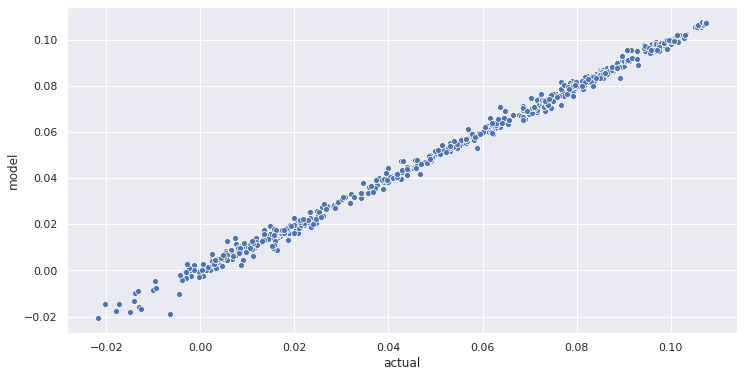

In [52]:
sns.scatterplot(compare.actual, compare.model)
plt.show()

### Regenerating the model generated S\$NEER values

In [53]:
calibrate = y_hat.to_frame().join(rebase_levels.sneer, how='outer')
calibrate.sneer = calibrate.sneer.fillna(method='ffill')
calibrate.columns = ['y_hat', 'sneer']

In [54]:
calibrate['sneer_model'] = np.exp(calibrate.y_hat) * calibrate.sneer 
calibrate.dropna(inplace=True)

In [55]:
calibrate.tail()

,y_hat,sneer,sneer_model
2020-10-30,0.002629,125.06,125.389193
2020-11-06,0.004623,125.06,125.639476
2020-11-13,0.006015,125.06,125.814482
2020-11-20,0.005335,125.06,125.728932
2020-11-27,0.006499,125.06,125.875432


---
## Model Performance Analysis

### Plots

The regression model generated S\\$NEER that tracks the official S\\$NEER closely.

In [56]:
official_sneer = sneer.sneer
model_sneer = calibrate.sneer_model

In [57]:
all_sneer = official_sneer.to_frame().join(model_sneer, how='right')
all_sneer.columns = ['official','model']

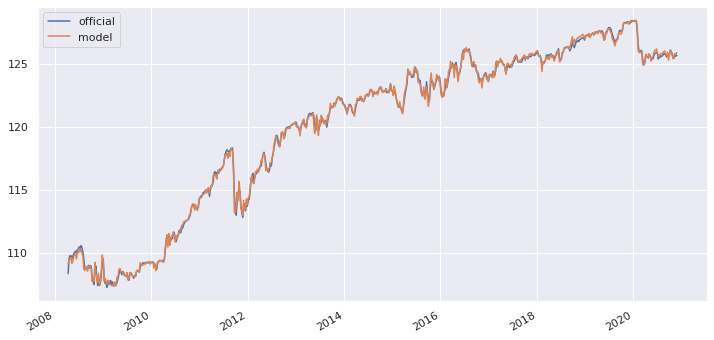

In [58]:
all_sneer.plot(figsize=(12,6))
plt.show()

### Scatter Plots

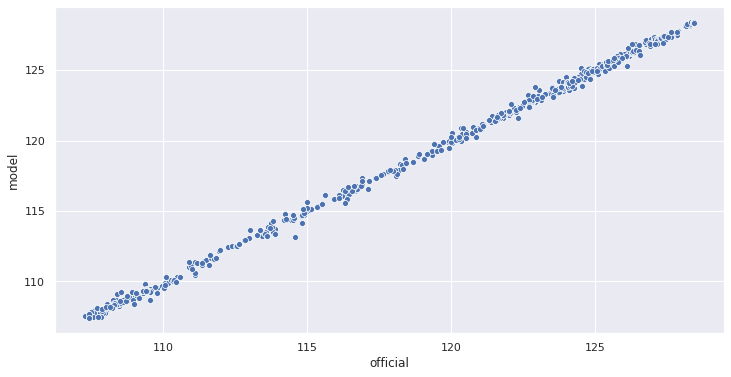

In [59]:
sns.scatterplot(all_sneer.official, all_sneer.model)
plt.show()

### Correlation

The model S\\$NEER is 99.9% correlated with the official S\\$NEER index.  In terms of weekly returns, they are 73% correlated. 

In [60]:
all_sneer.corr()

,official,model
official,1.000000,0.999394
model,0.999394,1.000000


In [61]:
all_sneer.pct_change().dropna().corr()

,official,model
official,1.000000,0.732884
model,0.732884,1.000000


### Deviation

All except one point have less than 1% deviation from the official S\\$NEER.

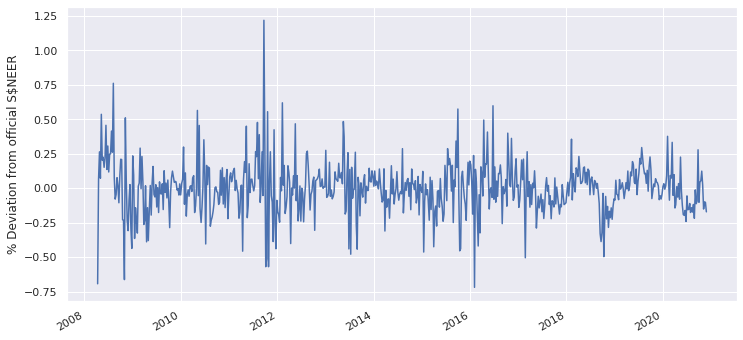

In [62]:
ax = ((all_sneer.official - all_sneer.model)/all_sneer.official*100).plot(figsize=(12,6))
ax.set_ylabel('% Deviation from official S\$NEER')
plt.show()

---
## Style Analysis

This analysis returns the optimal weights that minimizes the tracking error between a portfolio of the explanatory variables (X) and the dependent variable (y).

In [63]:
print('Explanatory variables: \n{}\n'.format(X.columns.to_list()))
print('Dependent variables: \n{}'.format(y.name.upper()))

Explanatory variables: 
['EUR', 'GBP', 'USD', 'AUD', 'CAD', 'CNY', 'INR', 'IDR', 'JPY', 'KRW', 'MYR', 'TWD', 'PHP', 'THB', 'VND']

Dependent variables: 
SNEER


In [64]:
print('Date Range: from {} to {}'.format(y.index[0].strftime(format='%d %b %Y'), 
                                         y.index[-1].strftime(format='%d %b %Y')))

Date Range: from 11 Apr 2008 to 27 Nov 2020


Based on all data between Apr 2008 to Nov 2020, currencies with the top 5 weightage are USD, CNY, MYR, EUR and JPY.  This is consistent with many similar analysis done by other analysts.  Note that USD weightage includes those countries that are pegged to it.  For example, HKD.

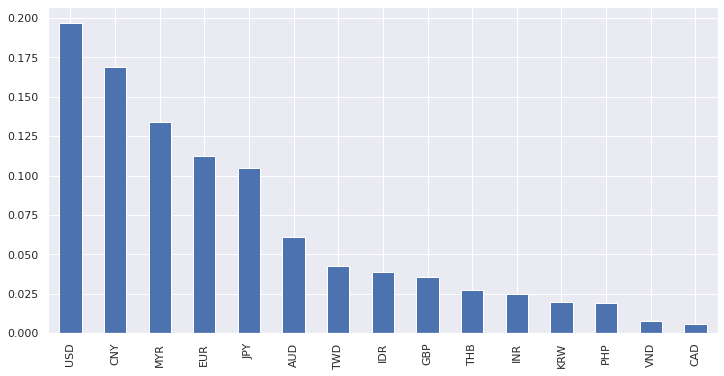

In [65]:
wgts = erk.style_analysis(y, X)

wgts.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.show()

Similarity analysis can be done on rolling basis.  Over a rolling window, we can show the changes in currency weightage implied in the S\\$NEER index, showing the trend of the trade weighted weights.

In [66]:
def rolling_style(data, window, skip=1):
    results = []
    nrow, ncol = data.shape
    
    for i in tqdm(range(window, nrow, skip)):
        weight = {}
        subdata = data.iloc[i-window:i]
        X = subdata.iloc[:,1:]
        y = subdata.iloc[:,0]    
        result = erk.style_analysis(y, X)
        for idx in result.index:
            weight['date'] = subdata.index[-1]
            weight[idx] = result[idx]
        results.append(weight)
        
    return pd.DataFrame(results)

def plot_rolling_style(results):
    # We need to transform the data from raw data to percentage (fraction)
    style_results_perc = results.divide(results.sum(axis=1), axis=0)*100

    ax = style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), 
                            title='{} Style Analysis'.format('S$NEER Calibrated Weights'), ylim=(0,100))
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    ax.margins(x=0)
    plt.show()

2-year (104 weeks) rolling period every 1 year (52 week)

In [67]:
style_results = rolling_style(Xy, 104, 52)
style_results.set_index('date', inplace=True)

In [68]:
top8 = wgts.sort_values(ascending=False).index[0:8].to_list()
top8

['USD', 'CNY', 'MYR', 'EUR', 'JPY', 'AUD', 'TWD', 'IDR']

In [69]:
style_results_top8 = style_results[top8]
style_results_top8['OTH'] = 1-style_results_top8.sum(axis=1)
style_results_top8.tail()

,USD,CNY,MYR,EUR,JPY,AUD,TWD,IDR,OTH
date,,,,,,,,,
2016-03-24,0.220254,0.116116,0.121781,0.123419,0.090870,0.040509,0.070207,0.057229,0.159615
2017-03-24,0.182650,0.123135,0.122748,0.133141,0.088124,0.027204,0.020703,0.067512,0.234784
2018-03-23,0.176952,0.127959,0.104840,0.143487,0.099986,0.041568,0.063427,0.049267,0.192515
2019-03-22,0.171878,0.116557,0.105745,0.136294,0.097441,0.054879,0.042927,0.046520,0.227760
2020-03-20,0.188276,0.114137,0.124162,0.151089,0.070393,0.049102,0.008001,0.035063,0.259777


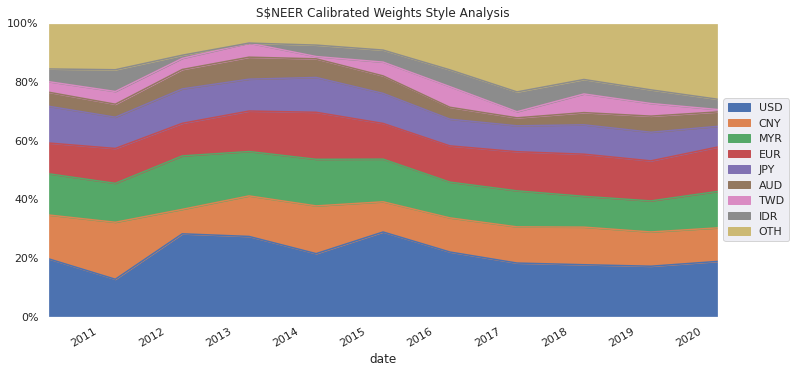

In [70]:
plot_rolling_style(style_results_top8)

---
## Rolling Regression Model

An attempt to build regression models on rolling windows of past data to estimate S\\$NEER index value given latest exchange rate data available at that point in time.  Regression model is built using recent seen data up to the time model is used in calculating the S\\$NEER index value with exchange rates observable at that time.  Unlike the above analaysis, unseen data are not used to construct the model.

Smaller rolling windows ensure only the latest data are used for regression and model building.  These data are most relevant when there significant changes to the global economy and MAS monetary actions.  Given that MAS policy decisions are adhoc and done on discretion, with no additional information on policy parameters, we should not expect such model to perform better than the one above in which we use all data points available.  On the other hand, the model may perform well during long periods of no intervention.

In [71]:
def rolling_predict(data, window, debug=False):
    results = []
    nrow, ncol = data.shape
    
    for i in tqdm(range(window, nrow)):
        
        result = {}
        subdata = data.iloc[i-window:i]

        if debug:
            print('{} - {} - {} - {} - {}'.format(i, data.index[i], subdata.index[0], subdata.index[-1], subdata.shape))
        
        X = subdata.iloc[:,1:]
        y = subdata.iloc[:,0]  

        model = erk.regress(y, X)
        
        remove_ccy = [ccy for ccy in model.pvalues[model.pvalues > 0.05].index.to_list() if ccy != 'Alpha']

        subdata = subdata.drop(remove_ccy, axis=1)
        X = subdata.iloc[:,1:]
        y = subdata.iloc[:,0]  
        model = erk.regress(y, X)
        
        X_hat = data.drop(remove_ccy, axis=1).iloc[i,1:].to_frame().T
        
        y_hat = erk.predict(model, X_hat)
        result['date'] = data.index[i]
        result['rolling_model'] = y_hat.values[0]
        
        results.append(result)
        
    results = pd.DataFrame(results)
    return results

2-year (104 weeks) rolling windows

In [72]:
y_rolling_model = rolling_predict(Xy, 104)
y_rolling_model.set_index('date', inplace=True)

### Comparing the actual and model generated dependant variable (y)

In [73]:
compare = compare.join(y_rolling_model, how='right')

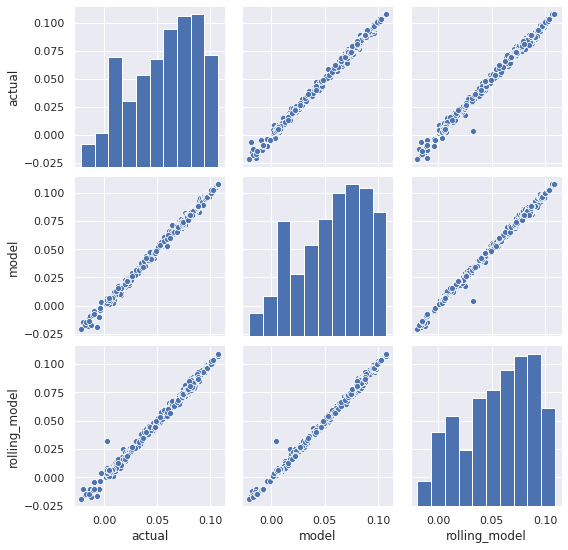

In [74]:
plot_pairs(compare, compare.columns)
plt.show()

### Regenerating the model generated S\$NEER values

In [75]:
calibrate = y_rolling_model.join(calibrate, how='left')
calibrate['sneer_rolling_model'] = np.exp(calibrate.rolling_model) * calibrate.sneer
calibrate.dropna(inplace=True)

In [76]:
calibrate.tail()

,rolling_model,y_hat,sneer,sneer_model,sneer_rolling_model
date,,,,,
2020-10-30,0.003618,0.002629,125.06,125.389193,125.513343
2020-11-06,0.006104,0.004623,125.06,125.639476,125.825683
2020-11-13,0.006533,0.006015,125.06,125.814482,125.879639
2020-11-20,0.005755,0.005335,125.06,125.728932,125.781802
2020-11-27,0.006417,0.006499,125.06,125.875432,125.865100


In [77]:
all_sneer = all_sneer.join(calibrate.sneer_rolling_model, how='right')

In [78]:
all_sneer.columns = ['official','model','rolling_model']

### Performance Analysis

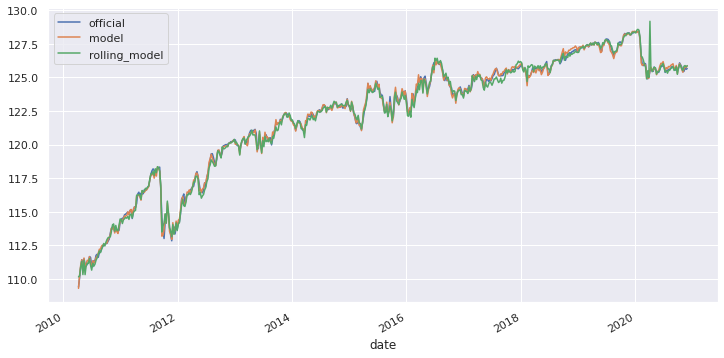

In [79]:
all_sneer.plot(figsize=(12,6))
plt.show()

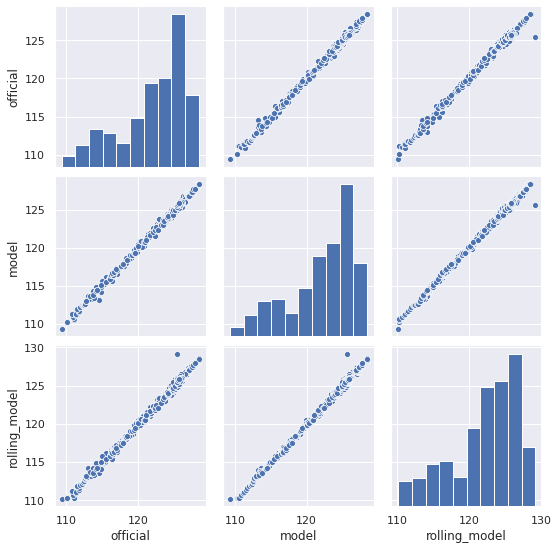

In [80]:
plot_pairs(all_sneer, all_sneer.columns)
plt.show()

In [81]:
all_sneer.corr()

,official,model,rolling_model
official,1.000000,0.998828,0.997670
model,0.998828,1.000000,0.998082
rolling_model,0.997670,0.998082,1.000000


In [82]:
all_sneer.pct_change().dropna().corr()

,official,model,rolling_model
official,1.000000,0.732925,0.575715
model,0.732925,1.000000,0.843395
rolling_model,0.575715,0.843395,1.000000


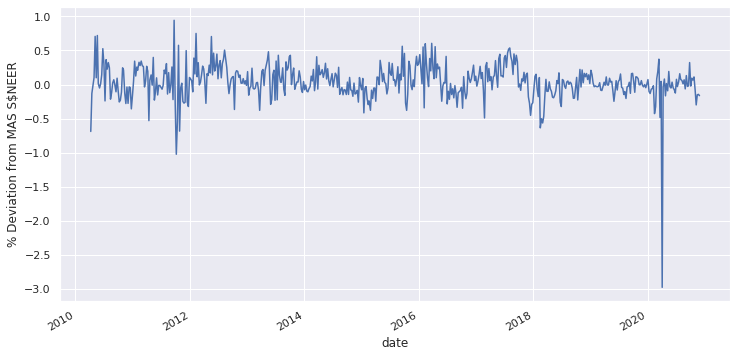

In [83]:
ax = ((all_sneer.official - all_sneer.rolling_model)/all_sneer.official*100).plot(figsize=(12,6))
ax.set_ylabel('% Deviation from MAS S\$NEER')
plt.show()